In [1]:
import exVAFm2 as exVAF
import numpy as np
va=exVAF.VAF(fname='/home/fukushim/software/flame_main_local/lat/to_strl_sdemo.lat')
from scipy.optimize import minimize

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['font.size'] = 30
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = [20,12]
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.linewidth'] = 2.0
plt.rcParams['lines.linewidth'] = 2.0
colors = ['r','green','b','m','darkorange','cyan','olivedrab']

In [3]:
### search element ###
corh = np.array(va.getindexu("*DCH*"))
corv = np.array(va.getindexu("*DCV*"))
cors = np.array(va.getindexu("*DC*"))
sols = np.array(va.getindexu("*SOL*"))
bpms = np.array(va.getindexu("*BPM*"))
pms  = np.array(va.getindexu("*_PM*"))

In [4]:
va.BC0[0][0]=-0.1

In [5]:
sa=va.tcs2()

In [6]:
sa[0]

(1,
 State: moment0 mean=[7](-0.0992197,1.08371e-05,0.0138543,6.67853e-06,-0.00133254,0.000309995,1))

In [4]:
# calc cost function with inputted corrector kick angles
def cor2bpm(val, corh, corv):
    global sola,solx, ncount
    ncount +=1
    
    kcorh = val[0::2] # input kick angle [rad] for horizontal
    kcorv = val[1::2] # input kick angle [rad] for vertical
    
    # set corrector parameters
    for i,(j,k) in enumerate(zip(corh,corv)):
        #set parameter 'theta_x'(kick angle [rad]) of corrector
        va.setvalue(j,'theta_x',float(kcorh[i]))
        va.setvalue(k,'theta_y',float(kcorv[i]))

    # run simulation
    va.tcs()
    
    #bpm reading values
    xbpms = va.LD[bpms,1] # x center [mm]
    ybpms = va.LD[bpms,2] # y center [mm]
    rbpms = np.sqrt(xbpms*xbpms+ybpms*ybpms) # r center [mm]
    
    # calculate cost function
    cost = np.amax(rbpms)*np.average(rbpms)*np.std(rbpms)
    
    # store best input kick angles
    if cost<sola :
        sola = cost
        solx = val
    return(cost)

# reset corrector parameters (back to baseline)
def cor2reset():
    for i,(j,k) in enumerate(zip(corh,corv)):
        va.setvalue(j,'theta_x',0.0)
        va.setvalue(k,'theta_y',0.0)
    va.tcs()

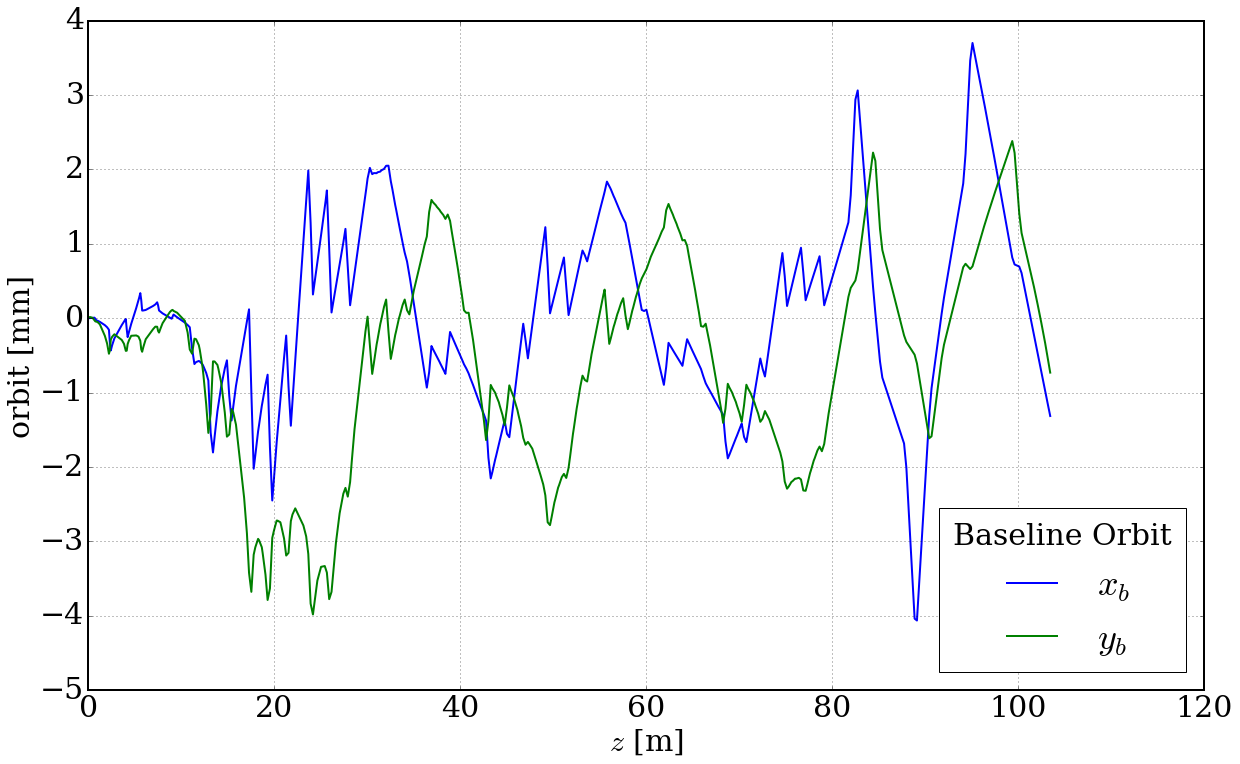

In [15]:
### Calculate baseline (all correcrtor off) ###
cor2reset()
### Plotting ###
plt.plot(va.LD[0:,0],va.LD[0:,1], label='$x_b$')
plt.plot(va.LD[0:,0],va.LD[0:,2], label='$y_b$')
plt.legend(loc='best',title='Baseline Orbit')
plt.ylabel('orbit [mm]')
plt.xlabel('$z$ [m]')
plt.show()

In [17]:
# Set initial parameter for orbit correction
var = len(corh)+len(corv)#90 # number of correctors both x and y
x0 = np.zeros(var) # initial corrector kick angles (=0.0)
bnds = np.array([(-3e-3, 3e-3) for _ in range(len(x0))],dtype=float)

In [18]:
# Run minimization
sola = 1e256 # worst cost value
ncount = 0   # check number of evaluations

res=minimize(cor2bpm, # Objective function -> input list of kick angles, returns cost function.  
             x0,      # Initial input list of kick angles 
             args=(corh,corv,), # index list of correctors 
             method='l-bfgs-b', # minimization method
             bounds=bnds,       # boundaries of input values
             options={'maxiter':30, 'eps':1.0e-7} # optional parameters
                                        # maxiter: Maximum number of iterations
                                        # eps: Step size used for numerical approximation of the jacobian
            )

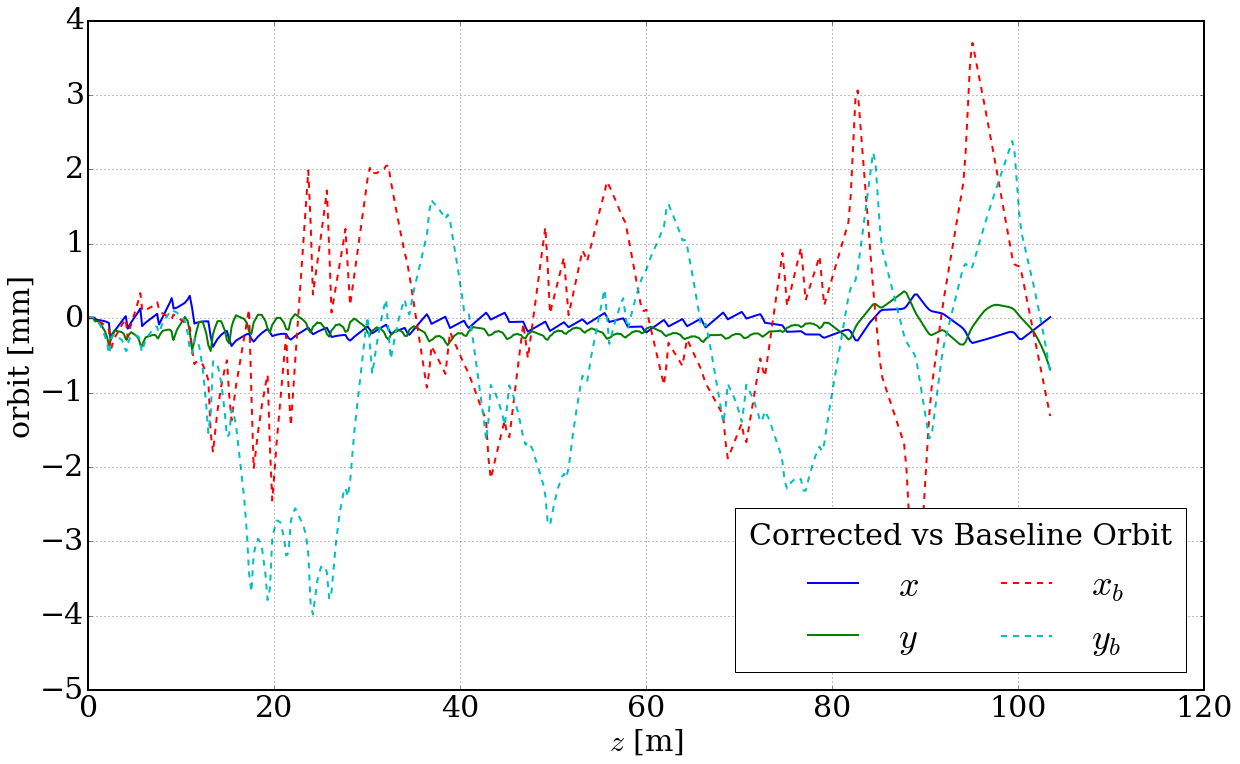

In [19]:
### Calculate with the best corrector parameters ###
cor2bpm(solx,corh,corv)
### Plotting ###
plt.plot(va.LD[:,0],va.LD[:,1], label='$x$')
plt.plot(va.LD[:,0],va.LD[:,2], label='$y$')

### Calculate baseline (all correcrtor off) ###
cor2reset()
### Plotting ###
plt.plot(va.LD[0:,0],va.LD[0:,1], '--',label='$x_b$')
plt.plot(va.LD[0:,0],va.LD[0:,2], '--',label='$y_b$')

plt.legend(loc='best',title='Corrected vs Baseline Orbit',ncol=2)
plt.ylabel('orbit [mm]')
plt.xlabel('$z$ [m]')
plt.show()

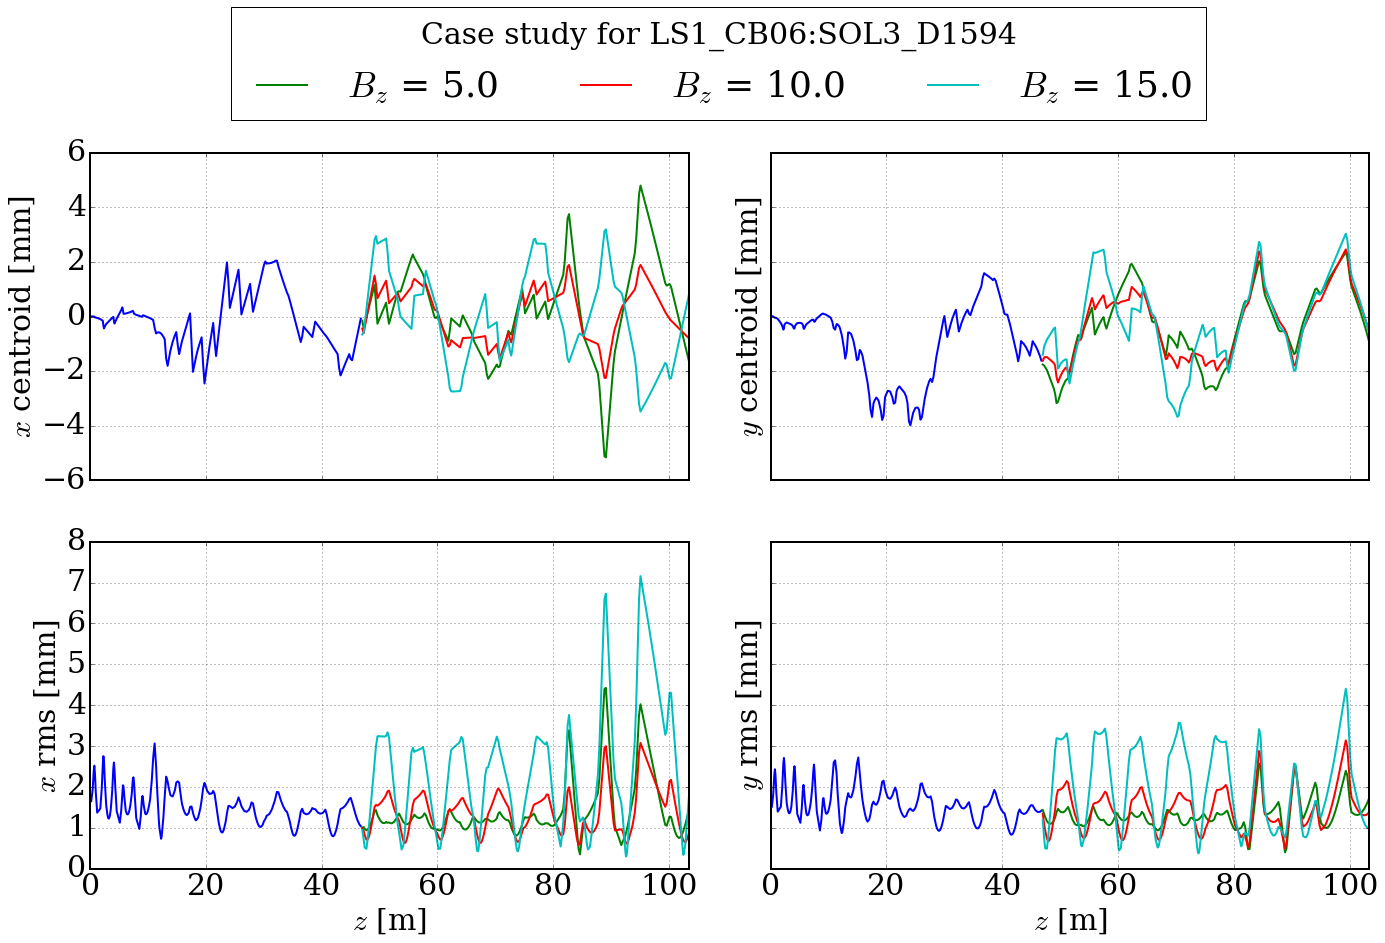

In [5]:
f,ax = plt.subplots(2,2,sharex='col',sharey='row')
### Calculate up to position A ###
s1,d1 = va.tcs_seg(0,409)
### Plotting ###
ax[0,0].plot(d1[:,0],d1[:,1])
ax[0,1].plot(d1[:,0],d1[:,2])
ax[1,0].plot(d1[:,0],d1[:,4])
ax[1,1].plot(d1[:,0],d1[:,5])
### Store beam data at A (to memory) ###
sd = va.SaveBeam(s1)

### Try 3 Bz cases ###
for i in [5.0, 10.0, 15.0]:
    ### Set Solenoid Parameter ###
    va.setvalue(410,'B',i)
    ### Calculate A to B ###
    s2,d2 = va.tcs_seg(409,822,S_in=sd)
    ### Plotting ###
    ax[0,0].plot(d2[2:,0],d2[2:,1],label='$B_z$ = '+str(i))
    ax[0,1].plot(d2[2:,0],d2[2:,2])
    ax[1,0].plot(d2[2:,0],d2[2:,4])
    ax[1,1].plot(d2[2:,0],d2[2:,5])


### Configure figure labels ###    
ax[0,0].set_ylabel('$x$ centroid [mm]')
ax[1,0].set_ylabel('$x$ rms [mm]')
ax[0,1].set_ylabel('$y$ centroid [mm]')
ax[1,1].set_ylabel('$y$ rms [mm]')
ax[1,0].set_xlabel('$z$ [m]')
ax[1,1].set_xlabel('$z$ [m]')
ax[0,0].legend(loc='upper center',title='Case study for LS1_CB06:SOL3_D1594',
               bbox_to_anchor=(1.05, 1.5) , ncol=3)
ax[0,0].set_xlim([d1[0,0],d2[-1,0]])
ax[0,1].set_xlim([d1[0,0],d2[-1,0]])
plt.tight_layout()

plt.show()

In [21]:
### LS1 -> FS1 lattice file ###
va=exVAF.VAF(fname='/home/fukushim/software/flame_main_local/lat/LS1FS1_lattice.lat')

### LS1 -> BDS lattice file ###
#va=exVAF.VAF(fname='/home/fukushim/software/flame_main_local/lat/ALL_lattice.lat')

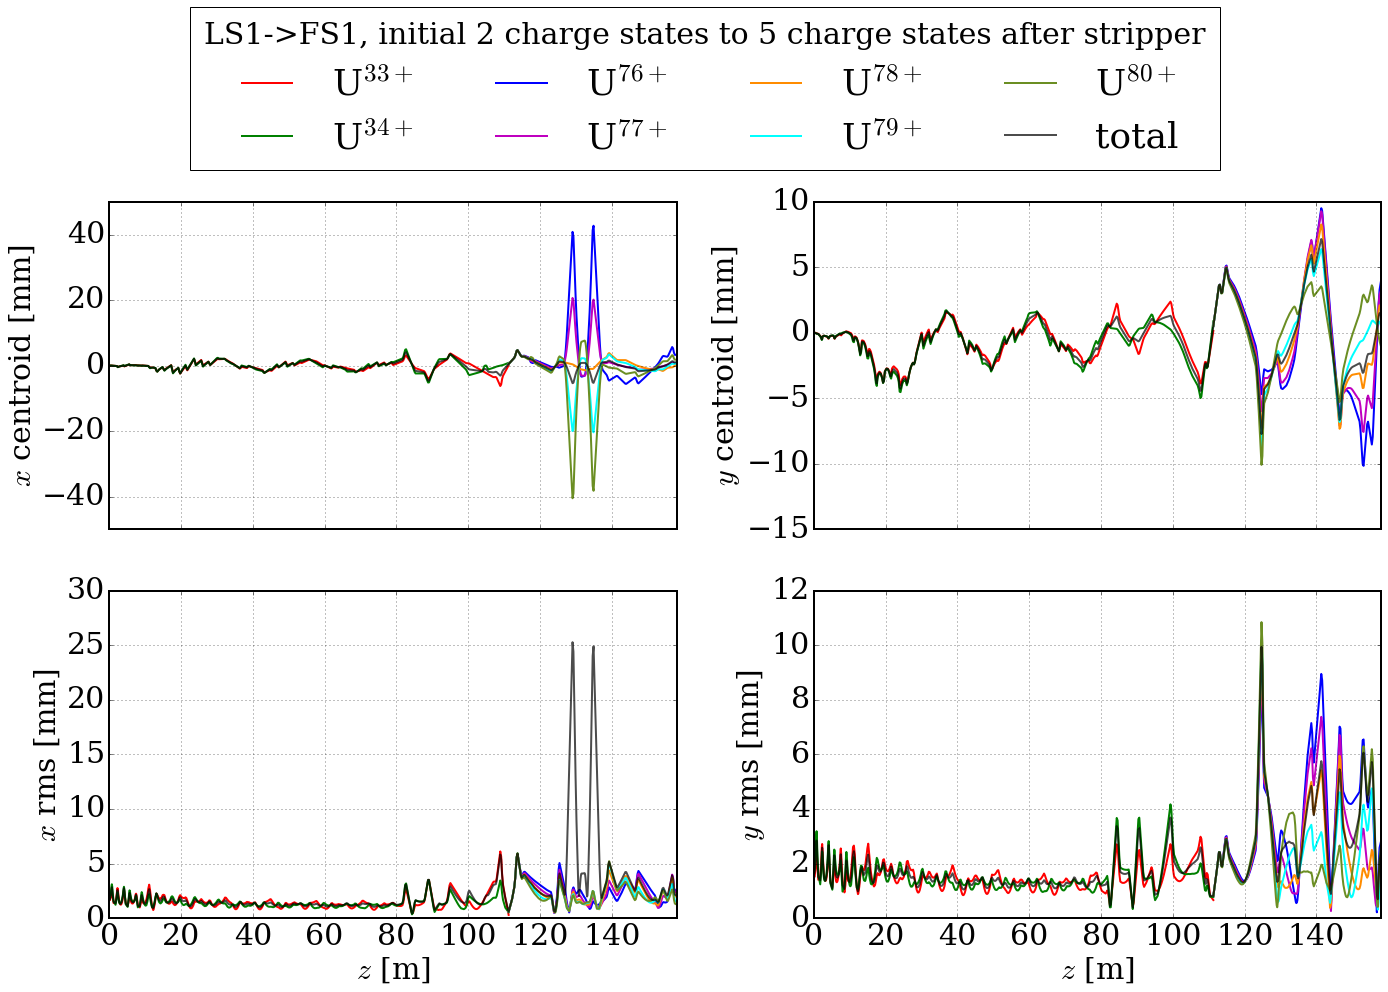

In [56]:
### Calculate LS1 -> FS1 ###
s1,d1,u = va.tcs_seg(allcs=2)

### Plotting ###
f2,ax = plt.subplots(2,2,sharex='col')

### Plot all charge states ###
for (i,j) in enumerate([33,34,76,77,78,79,80]):
    ax[0,0].plot(u[str(j)].pos,u[str(j)].x,colors[i],label='U$^{'+str(j)+'+}$')
    ax[0,1].plot(u[str(j)].pos,u[str(j)].y,colors[i])
    ax[1,0].plot(u[str(j)].pos,u[str(j)].xrms,colors[i])
    ax[1,1].plot(u[str(j)].pos,u[str(j)].yrms,colors[i])   
    
ax[0,0].plot(d1[:,0],d1[:,1],'k',alpha=0.7,label='total')
ax[0,1].plot(d1[:,0],d1[:,2],'k',alpha=0.7)
ax[1,0].plot(d1[:,0],d1[:,4],'k',alpha=0.7)
ax[1,1].plot(d1[:,0],d1[:,5],'k',alpha=0.7)


### Configure figure labels ###    
ax[0,0].set_ylabel('$x$ centroid [mm]')
ax[1,0].set_ylabel('$x$ rms [mm]')
ax[0,1].set_ylabel('$y$ centroid [mm]')
ax[1,1].set_ylabel('$y$ rms [mm]')
ax[1,0].set_xlabel('$z$ [m]')
ax[1,1].set_xlabel('$z$ [m]')
ax[0,0].legend(loc='upper center',title='LS1->FS1, initial 2 charge states to 5 charge states after stripper',
               bbox_to_anchor=(1.05, 1.65) , ncol=4)
ax[0,0].set_xlim([d1[0,0],d1[-1,0]])
ax[0,1].set_xlim([d1[0,0],d1[-1,0]])
plt.tight_layout()

plt.show()

In [121]:
u.keys()

['33', '34', '77', '76', '80', '79', '78']

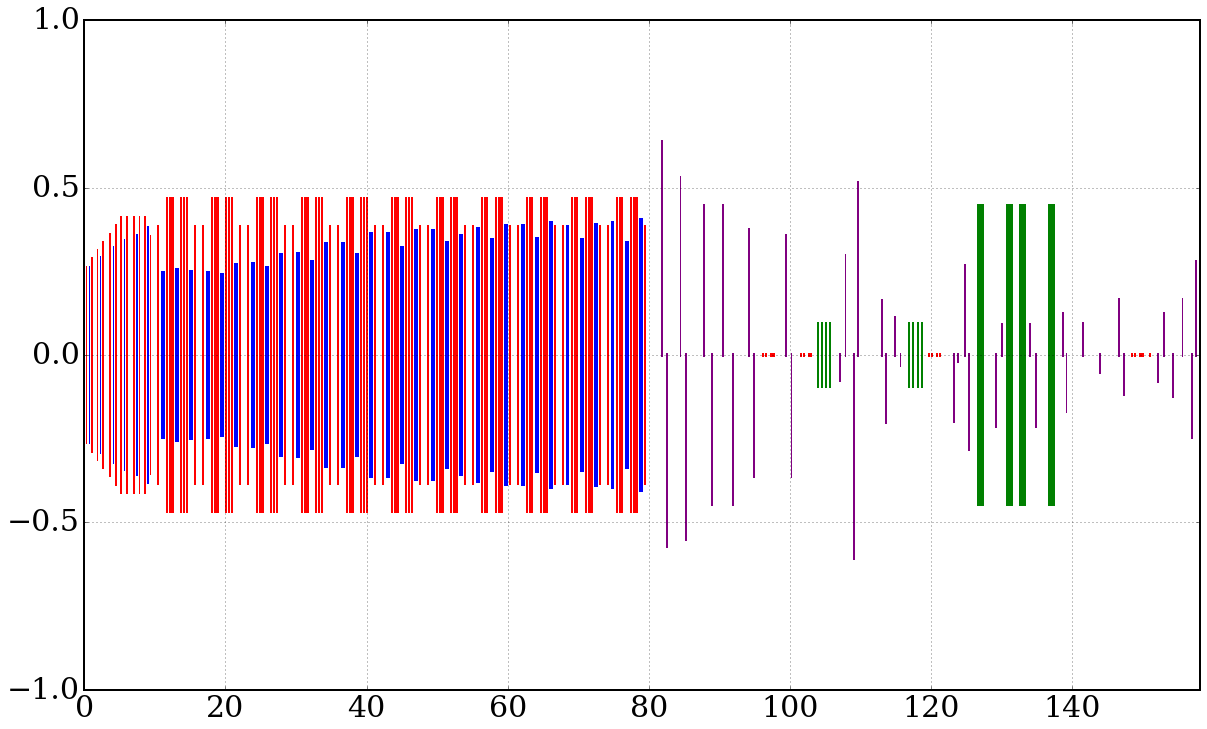

In [116]:
ax=plt.subplot2grid((1,1),(0,0))
pos = 0
lll = len(va.lat)
for i in range(lll):
    elem = va.M.conf(i)
    try:
        dl = elem['L']
    except:
        dl = 0.0
   
    if dl != 0.0:
        if elem['type'] == 'rfcavity':
            sf = elem['scl_fac']*np.cos(2.0*np.pi*elem['phi']/360.0) + 0.01
            ax.add_patch(ptc.Rectangle((pos, -sf/2),dl,sf,
                                       edgecolor='none',facecolor='red'))
        elif elem['type'] == 'solenoid':
            sf = elem['B']/10
            ax.add_patch(ptc.Rectangle((pos, -sf/2),dl,sf,
                                       edgecolor='none',facecolor='blue'))
        elif elem['type'] == 'quadrupole':
            sf = elem['B2']/40
            ax.add_patch(ptc.Rectangle((pos, -sf+sf/abs(sf)*0.005),dl,sf,
                                       edgecolor='none',facecolor='purple'))
        elif elem['type'] == 'sbend':
            sf = elem['phi']/5
            ax.add_patch(ptc.Rectangle((pos, -sf/2),dl,sf,
                                       edgecolor='none',facecolor='green'))
            
            
    pos+=dl

ax.set_ylim([-1,1])
ax.set_xlim([0,pos])
pass

In [10]:
s1,d1 = va.tcs_seg(0,2)

In [12]:
print s1.ref_IonEk, s1.ref_phis

500000.0 10.6665637601


In [41]:
dp = va.M.conf(3)['phi']*np.pi/180.0 - fyc(s1.ref_IonEk*1e6) - s1.ref_phis 
print dp

-6.54643582678


In [14]:
print s1.ref_IonEk
print s1.ref_IonW - s1.ref_IonEs

500000.0
500000.0


In [24]:
def fyc(ek):
    return 4.394*ek**-0.4965 - 4.731
    


In [25]:
fyc(s1.ref_IonEk*1e-6)

1.467997274862232

In [30]:
dp*180.0/np.pi - 360


202.03903717688115

In [40]:
(353.666-360)*np.pi/180.0

-0.11054915482132088

In [33]:
pi = va.M.conf(3)['phi']*np.pi/180.0
print pi

-0.610865238198
